In [1]:
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from cycler import cycler

## Strava API

In [2]:
#store the client_id, client_secret and refresh_token in a text file
api_dict = {}

with open('api_params.txt','r') as api_params:
    for line in api_params.readlines():
        key,value = line.partition(':')[::2]
        api_dict[key]= value.strip()


In [3]:
activities_url = 'https://www.strava.com/api/v3/athlete/activities'

auth_url='https://www.strava.com/oauth/token'
payload = {
    'client_id': api_dict['client_id'],
    'client_secret': api_dict['client_secret'],
    'refresh_token': api_dict['refresh_token'],
    'grant_type': 'refresh_token',
    'f': 'json'
}
    
res = requests.post(auth_url, data=payload,verify=False)


/Users/matthiaswenger/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.strava.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [4]:
access_token = res.json()['access_token']

header = {'Authorization': 'Bearer ' + access_token}


page= 1
requested_data = []
while True:
    param = {'per_page':200, 'page':page}
    response = requests.get(activities_url,headers=header,params=param).json()
    if len(response)==0:
        break
    requested_data.append(response)
    page+=1


In [5]:
#unpack all the received responses
df =pd.DataFrame(*requested_data)

## Data Preprocessing 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resource_state                 144 non-null    int64  
 1   athlete                        144 non-null    object 
 2   name                           144 non-null    object 
 3   distance                       144 non-null    float64
 4   moving_time                    144 non-null    int64  
 5   elapsed_time                   144 non-null    int64  
 6   total_elevation_gain           144 non-null    float64
 7   type                           144 non-null    object 
 8   sport_type                     144 non-null    object 
 9   workout_type                   143 non-null    float64
 10  id                             144 non-null    int64  
 11  start_date                     144 non-null    object 
 12  start_date_local               144 non-null    obj

In [7]:
df.head(3)

,resource_state,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,...,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,average_watts,kilojoules,device_watts,average_temp
0,2,"{'id': 31422514, 'resource_state': 1}",Lauf am Nachmittag,9325.9,3205,3357,123.6,Run,Run,0.0,...,8696766174,2E6B5C0B-EBFF-451D-984B-174A53C28A4F-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
1,2,"{'id': 31422514, 'resource_state': 1}",Lauf am Nachmittag,8565.8,3093,3093,110.3,Run,Run,0.0,...,8588982655,A44D2CAA-7864-4FE7-A4CE-475C832BCE6A-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN
2,2,"{'id': 31422514, 'resource_state': 1}",Lauf am Nachmittag,8716.5,3254,3254,156.6,Run,Run,0.0,...,8503813164,0EA06911-E5B6-413C-959C-0D9606B5D820-activity.fit,False,0,0,False,NaN,NaN,NaN,NaN


In [8]:
df['kilometres']= df['distance']/1000
df['start_date'] = pd.to_datetime(df['start_date'])
df['year'] = df['start_date'].dt.year
df['month'] = df['start_date'].dt.month
df['quarter'] = df['start_date'].dt.quarter
df['weekday'] = df['start_date'].dt.weekday
df['year_quarter'] = df['year'].astype(str) +"_" + df['quarter'].astype(str)
df['training_hours'] = df['moving_time']/3600

In [9]:
df['average_speed_strava'] = df['average_speed']
df['average_speed'] = df['kilometres']/df['training_hours']
df['avg_speed_elevation_gain'] = df['total_elevation_gain']/df['training_hours']

## Exploratory Data Analysis

In [10]:
total_df = df[['type','kilometres', 'elapsed_time']].groupby('type').aggregate({'kilometres':['count','mean'],'elapsed_time':'mean'})
total_df.columns = ['Activity_Count','Average_Distance', 'Elapsed_Time']

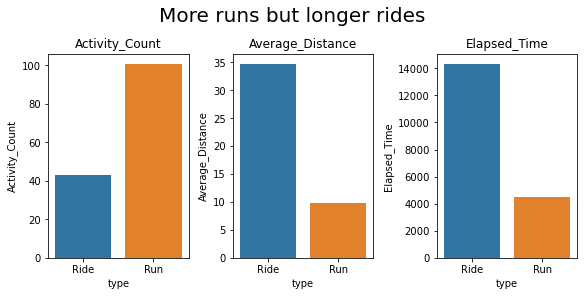

In [11]:
fig,ax = plt.subplots(1,3, figsize=(8, 4), constrained_layout=True)

measure = total_df.columns

for i,m in enumerate(measure):
    data = total_df[[m]]
    sns.barplot(data=data,x=data.index, y=m, ax=ax[i])
    ax[i].set_title(m)

plt.suptitle("More runs but longer rides", size=20)
plt.show()

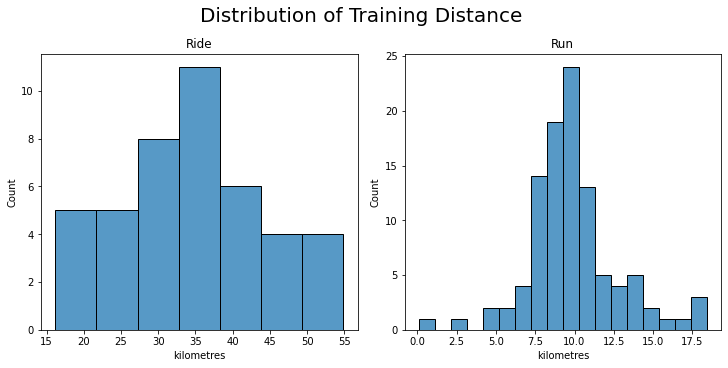

In [12]:
fig,ax = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)
data = df[df['type']=='Ride']
sns.histplot(data['kilometres'],ax=ax[0])
ax[0].set_title('Ride')
data = df[df['type']=='Run']
sns.histplot(data['kilometres'],ax=ax[1])
ax[1].set_title('Run')
plt.suptitle("Distribution of Training Distance ", size=20)
plt.show()

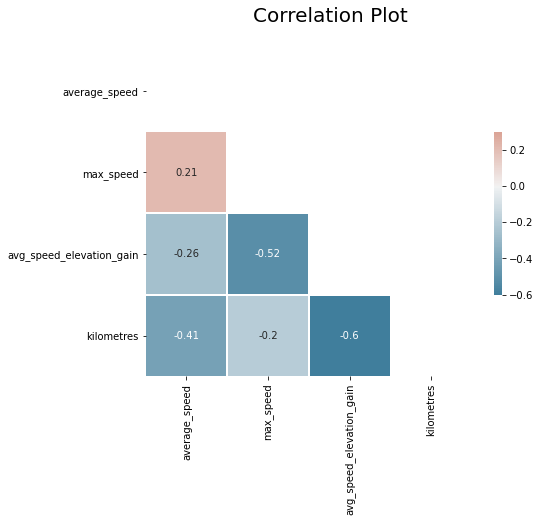

In [13]:
d = df[df['type']=='Run']
d = d[['average_speed','max_speed','avg_speed_elevation_gain','kilometres',]]
d = d.corr()
corr = d.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.suptitle("Correlation Plot",size=20)
plt.show()

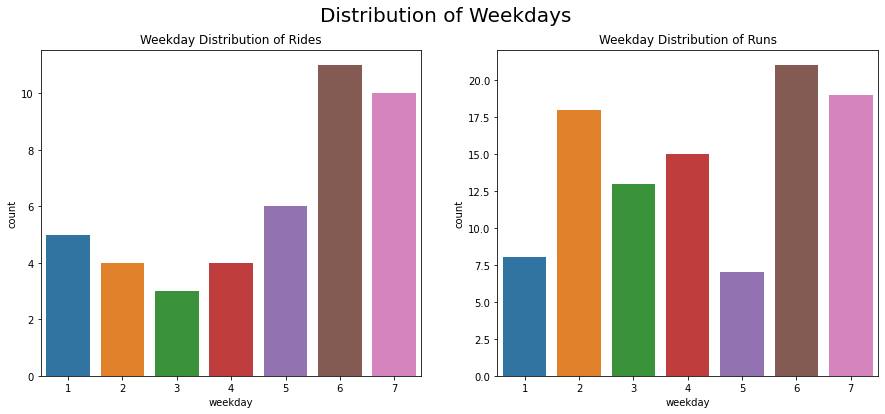

In [14]:
data = df[['type','weekday','id']].groupby(['type','weekday',]).count().reset_index()
data.columns = ['activity','weekday','count']
data['weekday']+=1

fig,ax = plt.subplots(1,2,figsize=(15,6))
for i,a in enumerate(['Ride','Run']):
    d= data[data['activity']==a]
    sns.barplot(data=d,x='weekday', y='count',ax=ax[i])
    ax[i].set_title(f"Weekday Distribution of {a}s")
    
plt.suptitle(f"Distribution of Weekdays",size=20)
plt.show()

## Time Series of Average Speed  

In [15]:
def make_ts_plot(data,measure1, measure2=None):
    fig,ax = plt.subplots(2,1,figsize=(15,6))
    for i,msr in enumerate(['Ride','Run']):
        ax[i].plot('start_date',measure1,data=data[data['type']==msr])
        ax[i].set_title(msr)
        ax[i].set_ylabel(measure1,color='blue')
        if measure2:
            ax2 = ax[i].twinx()
            ax2.plot('start_date',measure2,data=data[data['type']==msr], color='red')
            ax2.set_ylabel('dist',color='red')

            plt.suptitle(f"{measure1} and {measure2} over Time",size=20)
        else:
            plt.suptitle(f"{measure1} over Time",size=20)
    plt.show()


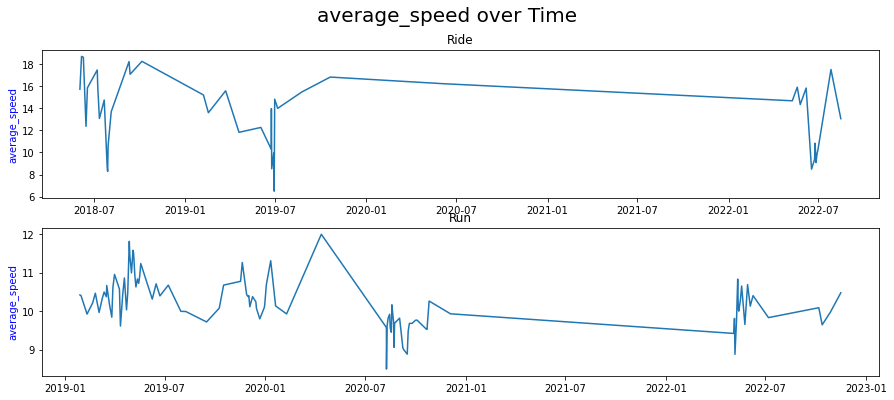

In [16]:
data = df[['type','start_date','average_speed','kilometres']].copy()
make_ts_plot(data,'average_speed')

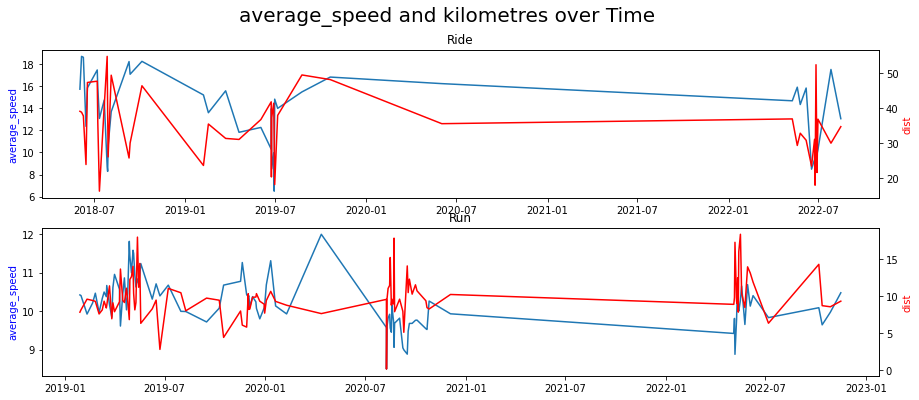

In [17]:
make_ts_plot(data,'average_speed','kilometres')

## Time Series per Category 

The code bellow groups the data in the categories {short,medium,long} which I derrived visually from the histograms above. 

In [18]:
def get_cats(x,activity,all_cats):
    """find the closest category based on smallest absolute distance"""
    cats = all_cats[activity]
    for key,val in cats.items():
        upper,lower=val
        if upper< x < lower:
            return key   

In [19]:
ride_cats = {'short':[0,30],'medium (most activities)':[30,40],'long':[40,999]}
run_cats = {'short':[0,7],'medium (most activities)':[7,12],'long':[12,999]}
all_cats = {'Ride':ride_cats,'Run':run_cats}

In [20]:
data = df[['type','start_date','year_quarter','average_speed','avg_speed_elevation_gain','kilometres']].copy()
data.loc[:,'dist_cat'] = data[['type','kilometres']].apply(lambda x: get_cats(x['kilometres'],x['type'],all_cats),axis=1)
data=data.groupby(['type','dist_cat','year_quarter']).mean().reset_index()

In [21]:
def make_cat_plot(data, activity,measure):
    data_runs = data[data['type']==activity]
    cats = set(data_runs['dist_cat'])
    ncols =2
    nrows =len(cats)//ncols+ len(cats)%ncols
    fig,ax = plt.subplots(nrows,ncols,figsize=(15,2.5*nrows),constrained_layout=True)
    ax = ax.flatten()


    for i,cat in enumerate(cats):
        ax[i].plot('year_quarter',measure,data=data_runs[data_runs['dist_cat']==cat])
        ax[i].set_title(f"Category {cat}")
        ax[i].set_ylabel(measure,color='blue')

    plt.suptitle(f"{activity}s per Category ({measure})",size=20)
    plt.show()

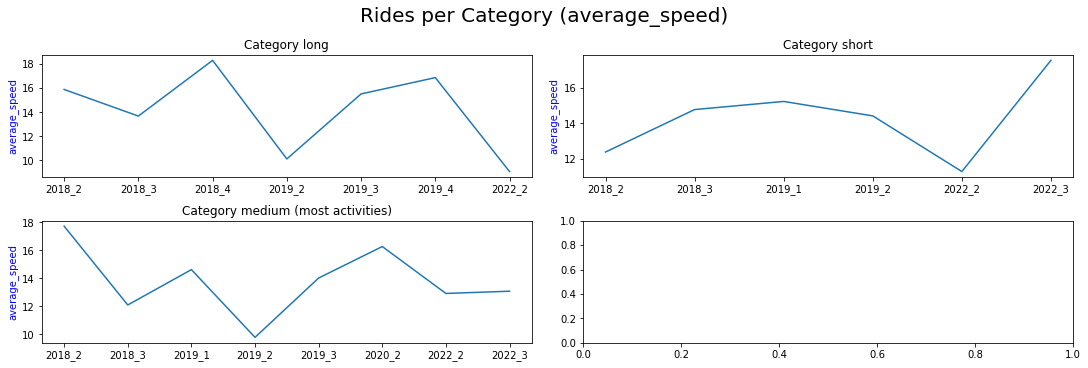

In [22]:
make_cat_plot(data,'Ride', 'average_speed')

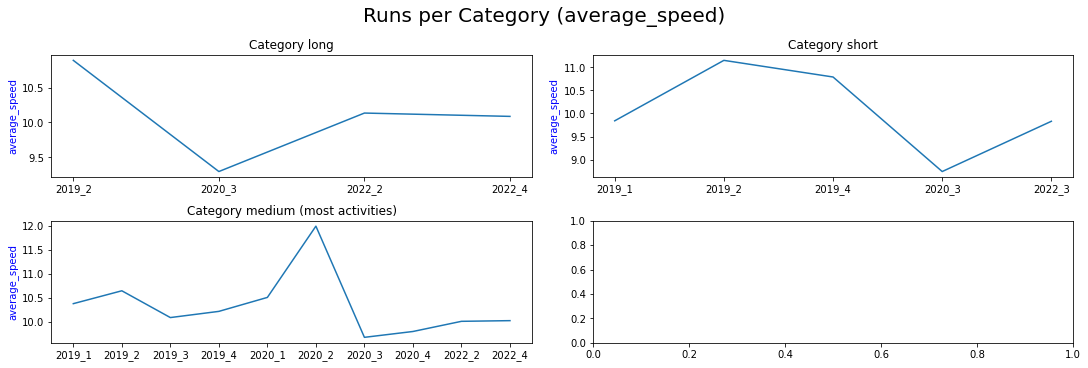

In [23]:
make_cat_plot(data,'Run','average_speed')

## Elevation Gain Speed :)

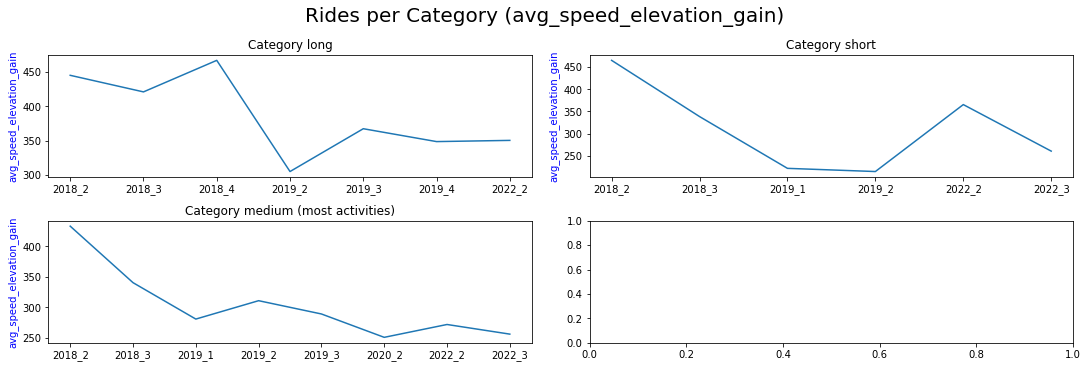

In [24]:
make_cat_plot(data,'Ride', 'avg_speed_elevation_gain')

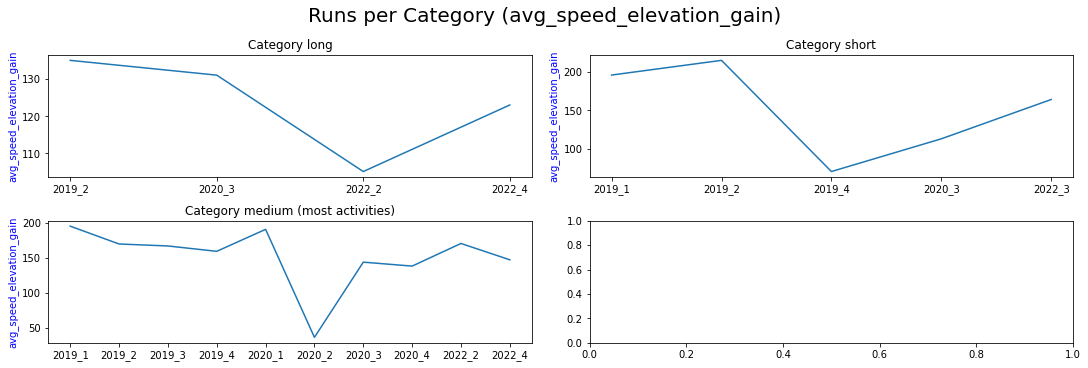

In [25]:
make_cat_plot(data,'Run', 'avg_speed_elevation_gain')